## Setup and Imports

In [2]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re
from collections import Counter
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
import warnings

In [3]:
# Suppress warnings
warnings.filterwarnings('ignore')

In [4]:
# Set plotting style
plt.style.use('ggplot')
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

In [13]:
# Define paths
ROOT_DIR = Path.cwd()  # Current working directory: /home/studio-lab-user/sentiment-analysis-research
RAW_DATA_DIR = ROOT_DIR / "data" / "raw"
PROCESSED_DATA_DIR = ROOT_DIR / "data" / "processed"

In [14]:
# Download NLTK resources if not already downloaded
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('punkt')
    nltk.download('stopwords')

print(f"Working directory: {os.getcwd()}")
print(f"Root directory: {ROOT_DIR}")

Working directory: /home/studio-lab-user/sentiment-analysis-research
Root directory: /home/studio-lab-user/sentiment-analysis-research


In [15]:
sst_path = RAW_DATA_DIR / "stanford_sentiment_treebank.csv"
if sst_path.exists():
    sst_df = pd.read_csv(sst_path)
    print(f"Loaded Stanford Sentiment Treebank with {len(sst_df)} rows")
else:
    print(f"Warning: SST dataset not found at {sst_path}")
    sst_df = None

Loaded Stanford Sentiment Treebank with 11855 rows


In [16]:
# Load Reddit dataset
reddit_path = RAW_DATA_DIR / "reddit_data.csv"
if reddit_path.exists():
    reddit_df = pd.read_csv(reddit_path)
    print(f"Loaded Reddit dataset with {len(reddit_df)} rows")
else:
    print(f"Warning: Reddit dataset not found at {reddit_path}")
    reddit_df = None

Loaded Reddit dataset with 37249 rows


## Data Overview

In [17]:
# Stanford Sentiment Treebank overview
if sst_df is not None:
    print("\n--- Stanford Sentiment Treebank Overview ---")
    print(f"Shape: {sst_df.shape}")
    print("\nColumns:")
    for col in sst_df.columns:
        print(f"- {col}: {sst_df[col].dtype}")
    
    print("\nSample rows:")
    display(sst_df.head())


--- Stanford Sentiment Treebank Overview ---
Shape: (11855, 2)

Columns:
- text: object
- label: int64

Sample rows:


,text,label
0,The Rock is destined to be the 21st Century 's...,0
1,The gorgeously elaborate continuation of `` Th...,0
2,Effective but too-tepid biopic,0
3,If you sometimes like to go to the movies to h...,0
4,"Emerges as something rare , an issue movie tha...",-1


In [20]:
 # Check for missing values
missing_vals = sst_df.isnull().sum()
if missing_vals.sum() > 0:
    print("\nMissing values:")
    print(missing_vals[missing_vals > 0])
else:
    print("\nNo missing values found.")


No missing values found.


In [24]:
# Reddit dataset overview
if reddit_df is not None:
    print("\n--- Reddit Dataset Overview ---")
    print(f"Shape: {reddit_df.shape}")
    print("\nColumns:")
    for col in reddit_df.columns:
        print(f"- {col}: {reddit_df[col].dtype}")
    print("\nSample rows:")
    display(reddit_df.head())


--- Reddit Dataset Overview ---
Shape: (37249, 2)

Columns:
- text: object
- label: int64

Sample rows:


,text,label
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


In [25]:
# Check for missing values
missing_vals = reddit_df.isnull().sum()
if missing_vals.sum() > 0:
    print("\nMissing values:")
    print(missing_vals[missing_vals > 0])
else:
    print("\nNo missing values found.")


Missing values:
text    100
dtype: int64


## Label Distribution Analysis

In [30]:
# Function to plot label distribution
def plot_label_distribution(df, title, label_col='labels'):
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(x=label_col, data=df)
    
    # Add count labels on top of bars
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'bottom', 
                    xytext = (0, 5), textcoords = 'offset points')

    plt.title(f'Label Distribution - {title}')
    plt.xlabel('Sentiment Label')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()
    
    # Print percentage distribution
    value_counts = df[label_col].value_counts(normalize=True) * 100
    print(f"\nPercentage Distribution - {title}:")
    for label, pct in value_counts.items():
        print(f"- {label}: {pct:.2f}%")

#### SST-3

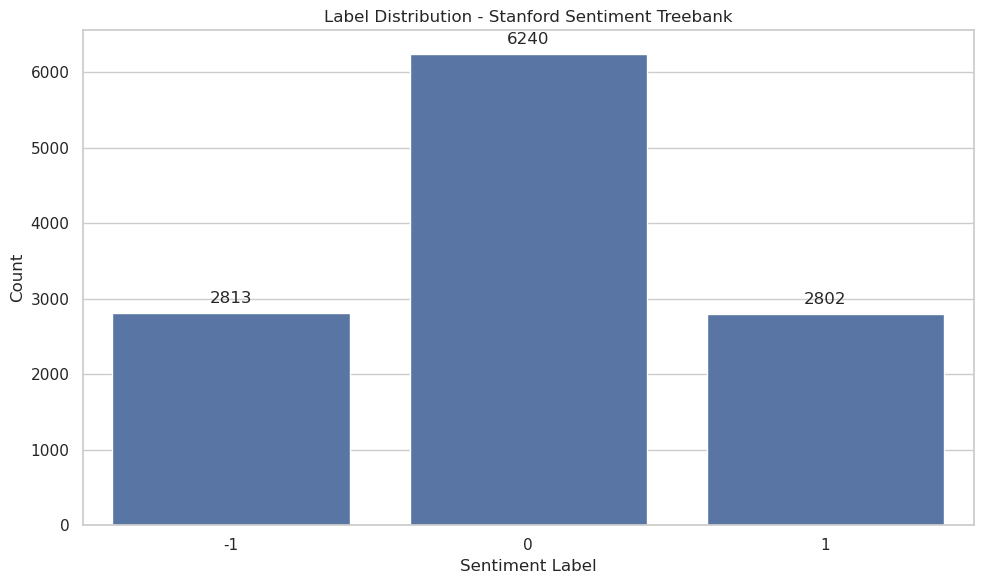


Percentage Distribution - Stanford Sentiment Treebank:
- 0: 52.64%
- -1: 23.73%
- 1: 23.64%


In [31]:
# Plot label distribution for SST
if sst_df is not None:
    plot_label_distribution(sst_df, "Stanford Sentiment Treebank")

#### Reddit

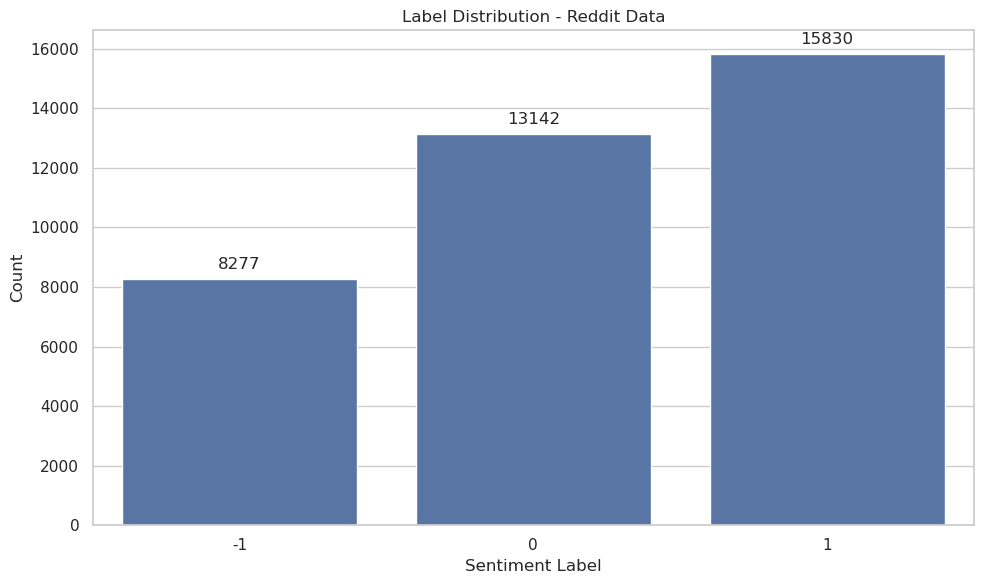


Percentage Distribution - Reddit Data:
- 1: 42.50%
- 0: 35.28%
- -1: 22.22%


In [32]:
# Plot label distribution for Reddit
if reddit_df is not None:
    plot_label_distribution(reddit_df, "Reddit Data")

## Text Length Analysis

In [41]:
def analyze_text_length(df, text_col='text', title=''):
    # Calculate text length with null/float handling
    df['text_length'] = df[text_col].apply(lambda x: len(str(x)) if pd.notna(x) else 0)
    
    # Plot histogram
    plt.figure(figsize=(12, 6))
    sns.histplot(df['text_length'], bins=50, kde=True)
    
    # Add vertical lines for mean and median
    mean_length = df['text_length'].mean()
    median_length = df['text_length'].median()
    
    plt.axvline(mean_length, color='r', linestyle='-', alpha=0.7, 
               label=f"Mean: {mean_length:.1f}")
    plt.axvline(median_length, color='g', linestyle='--', alpha=0.7, 
               label=f"Median: {median_length:.1f}")
    
    plt.title(f'Text Length Distribution - {title}')
    plt.xlabel('Text Length (characters)')
    plt.ylabel('Frequency')
    plt.legend()
    
    # Add text length stats
    print(f"\nText Length Statistics - {title}:")
    print(f"Min: {df['text_length'].min()}")
    print(f"Max: {df['text_length'].max()}")
    print(f"Mean: {mean_length:.2f}")
    print(f"Median: {median_length:.2f}")
    print(f"Std Dev: {df['text_length'].std():.2f}")
    
    # Plot text length by sentiment
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='label', y='text_length', data=df)
    plt.title(f'Text Length by Sentiment - {title}')
    plt.xlabel('Sentiment Label')
    plt.ylabel('Text Length (characters)')
    plt.tight_layout()

#### SST-3


Text Length Statistics - Stanford Sentiment Treebank:
Min: 4
Max: 283
Mean: 102.75
Median: 99.00
Std Dev: 51.02


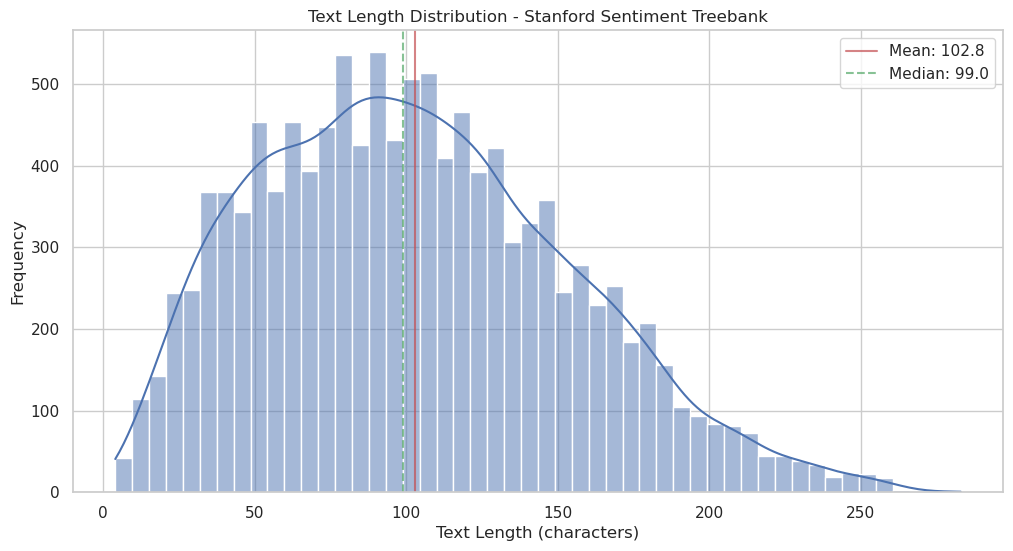

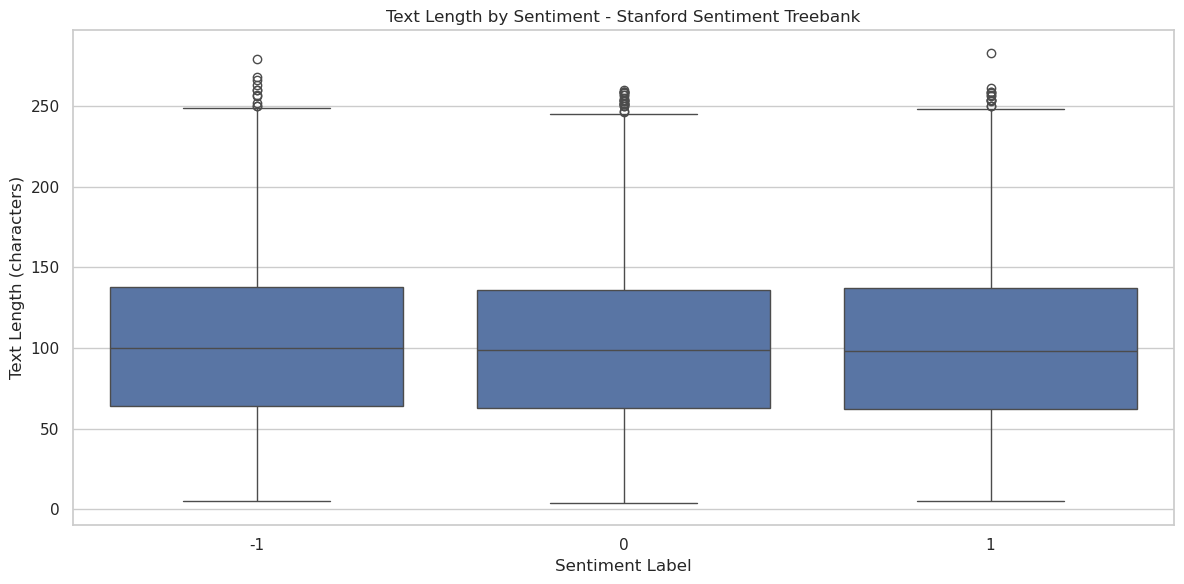

In [42]:
# Analyze text length for SST
if sst_df is not None:
    analyze_text_length(sst_df, title="Stanford Sentiment Treebank")

#### Reddit


Text Length Statistics - Reddit Data:
Min: 0
Max: 8665
Mean: 180.90
Median: 80.00
Std Dev: 358.10


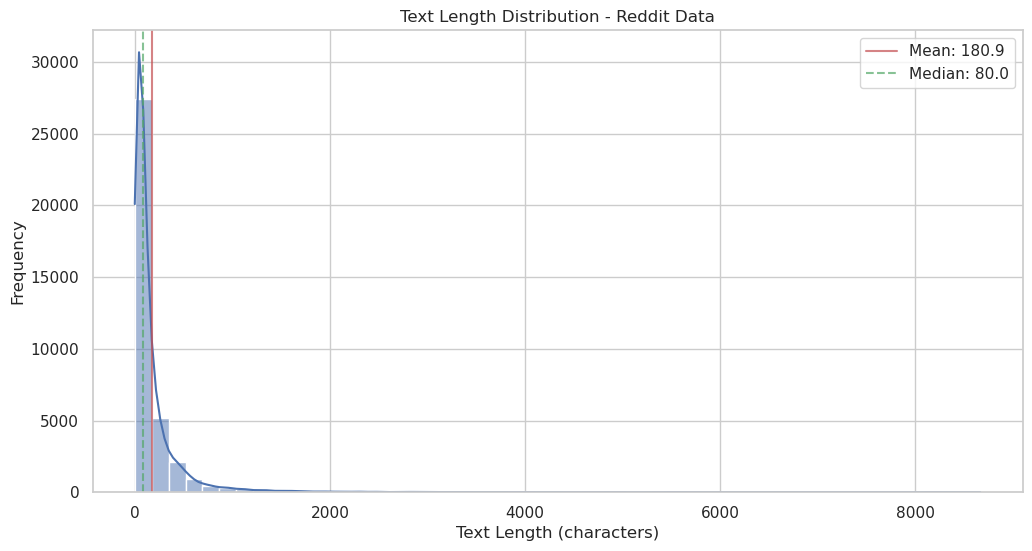

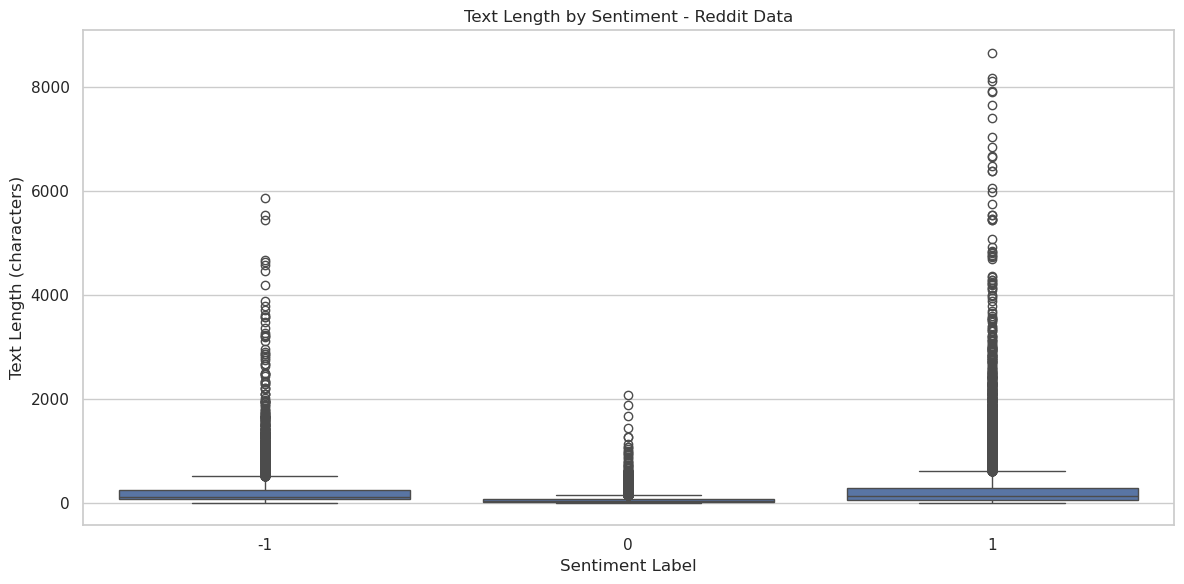

In [43]:
# Analyze text length for Reddit
if reddit_df is not None:
    analyze_text_length(reddit_df, title="Reddit Data")

## Word Frequency Analysis

In [44]:
# Function to create a word cloud
def create_wordcloud(df, text_col='text', title=''):
    # Handle NaN values and convert all to string
    text = ' '.join(df[text_col].fillna('').astype(str))
    
    # Generate word cloud
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white',
        max_words=100,
        contour_width=3
    ).generate(text)
    
    plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud - {title}', fontsize=20)
    plt.tight_layout()
    plt.show()

In [47]:
# Function to get top words by sentiment
def get_top_words_by_sentiment(df, text_col='text', label_col='label', n=20):
    stop_words = set(stopwords.words('english'))
    
    # Add some common words to stop words
    extra_stop_words = {'s', 't', 've', 'll', 're', 'm', 'd', 'em', 'just', 'get', 'also', 'go', 'would', 'could'}
    stop_words.update(extra_stop_words)
    
    # Initialize CountVectorizer
    vectorizer = CountVectorizer(
        max_features=10000,
        stop_words=list(stop_words),
        token_pattern=r'\b[a-zA-Z][a-zA-Z]{2,}\b'  # At least 3 chars, starting with letter
    )
    
    X = vectorizer.fit_transform(df[text_col].fillna('').astype(str))
    words = vectorizer.get_feature_names_out()
    
    # Group by sentiment and get top words
    top_words_by_sentiment = {}
    unique_labels = df[label_col].unique()
    
    for label in unique_labels:
        label_indices = df[df[label_col] == label].index
        label_counts = X[label_indices].sum(axis=0)
        label_word_counts = [(words[i], label_counts[0, i]) for i in range(len(words))]
        label_word_counts = sorted(label_word_counts, key=lambda x: x[1], reverse=True)
        top_words_by_sentiment[label] = label_word_counts[:n]
    
    # Plot top words by sentiment
    num_labels = len(unique_labels)
    fig, axes = plt.subplots(1, num_labels, figsize=(15, 6))
    
    if num_labels == 1:
        axes = [axes]
    for i, label in enumerate(sorted(unique_labels)):
        ax = axes[i]
        words, counts = zip(*top_words_by_sentiment[label])
        
        y_pos = np.arange(len(words))
        ax.barh(y_pos, counts)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(words)
        ax.invert_yaxis()  # Labels read top-to-bottom
        ax.set_title(f'Top Words for Label: {label}')
        
    plt.tight_layout()
    plt.show()
    
    return top_words_by_sentiment

#### SST-3

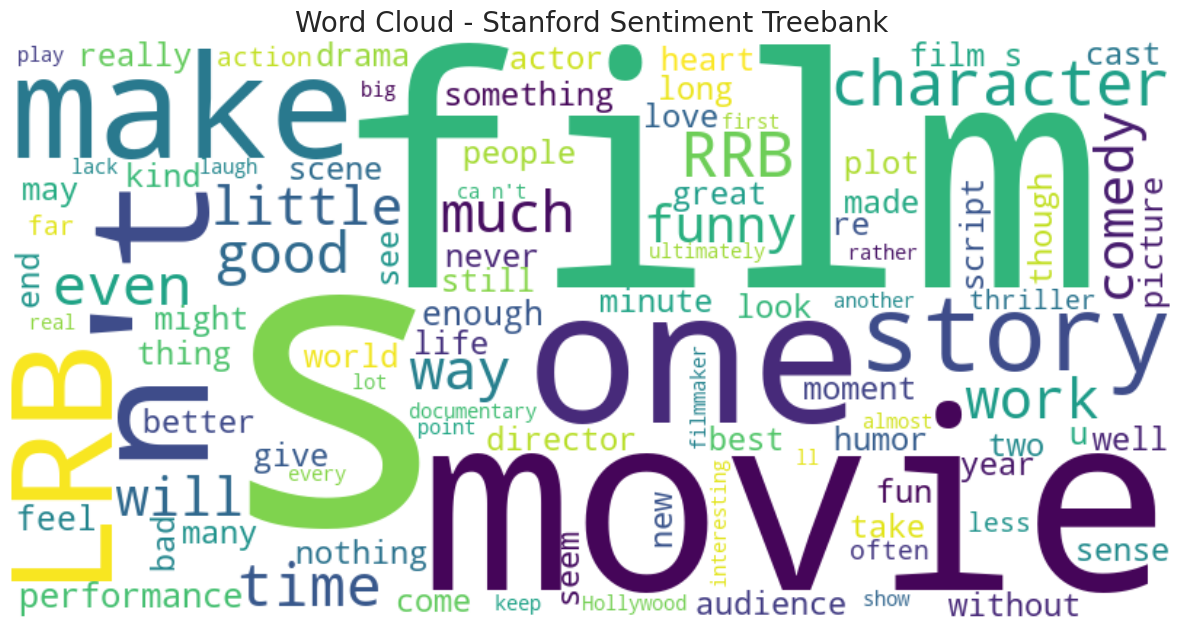

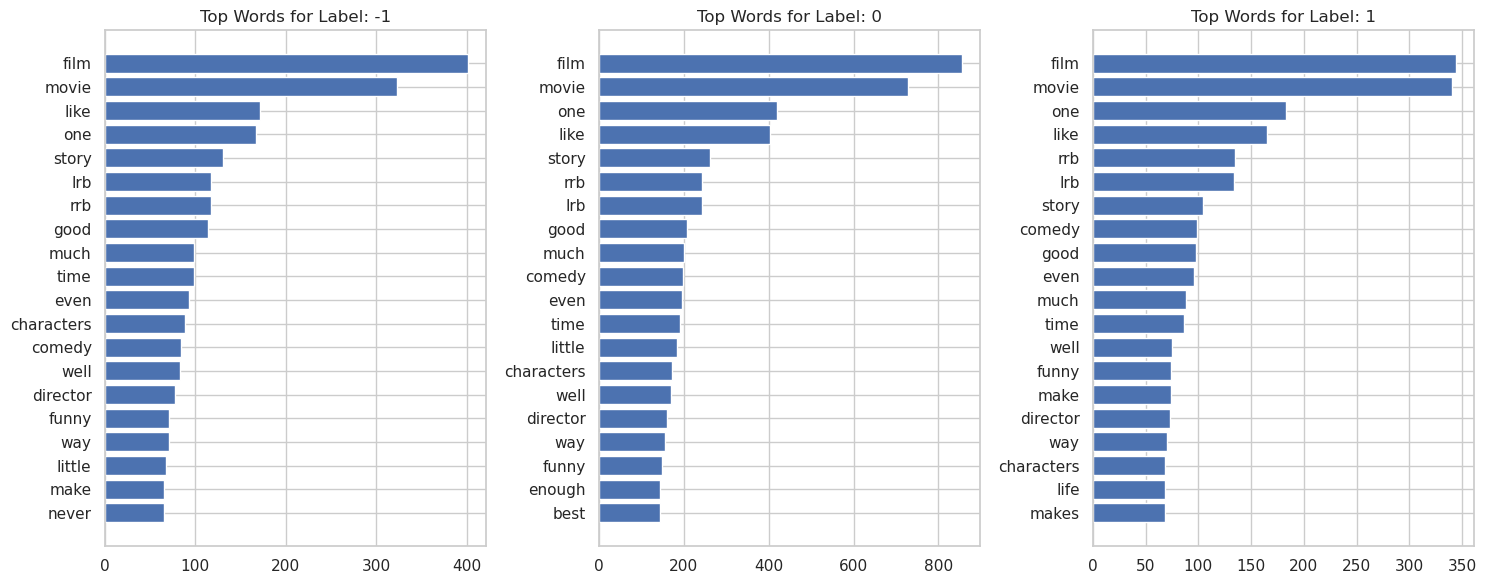

In [48]:
# Create word clouds
if sst_df is not None:
    create_wordcloud(sst_df, title="Stanford Sentiment Treebank")
    top_words_sst = get_top_words_by_sentiment(sst_df)

#### Reddit

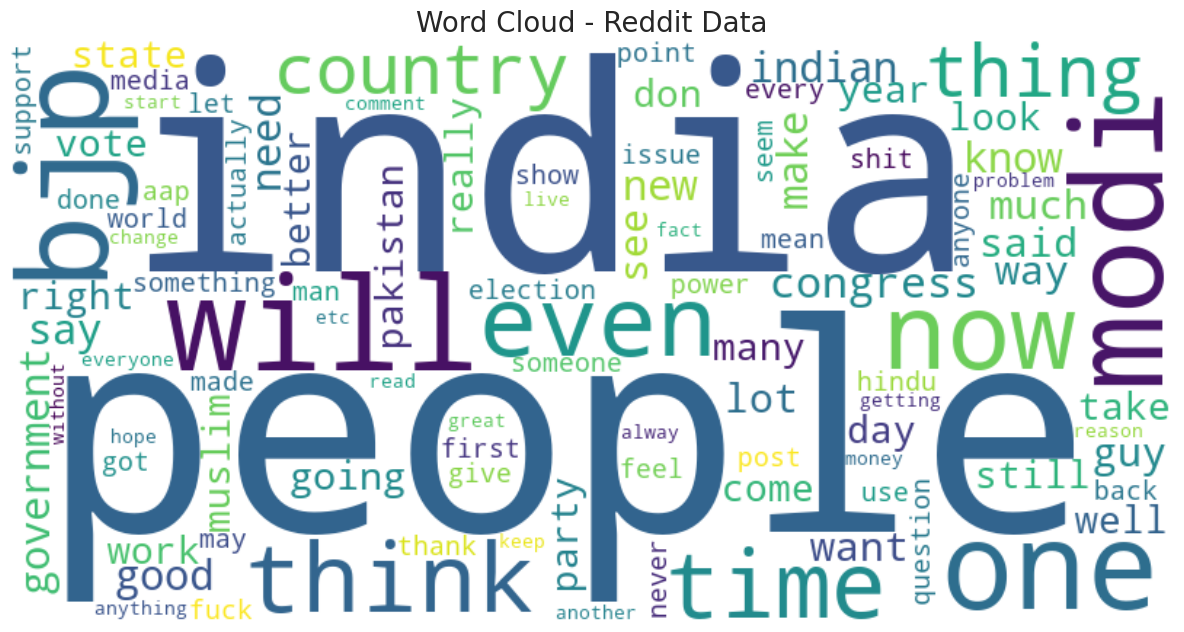

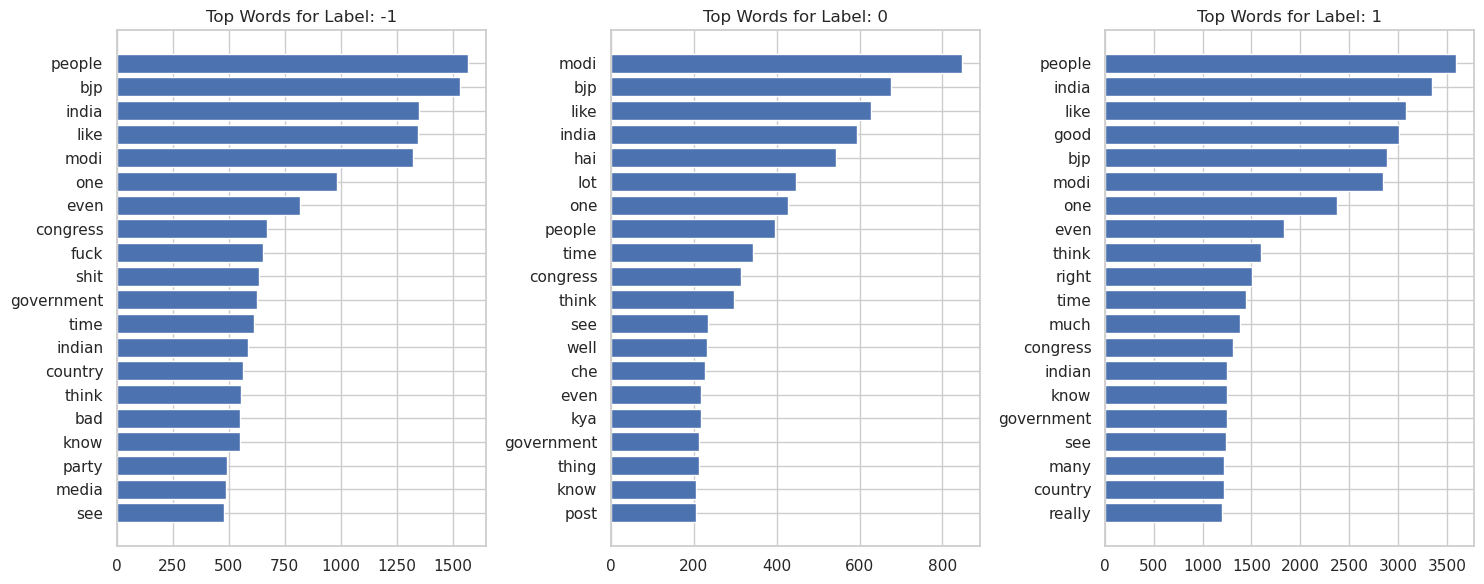

In [49]:
if reddit_df is not None:
    create_wordcloud(reddit_df, title="Reddit Data")
    top_words_reddit = get_top_words_by_sentiment(reddit_df)

## Class Imbalance Analysis


In [52]:
# Function to check class imbalance
def check_class_imbalance(df, label_col='label', title=''):
    label_counts = df[label_col].value_counts()
    total = len(df)
    
    # Calculate imbalance ratio (max/min)
    imbalance_ratio = label_counts.max() / label_counts.min()
    
    print(f"\nClass Imbalance Analysis - {title}")
    print(f"Total samples: {total}")
    print(f"Label counts: {label_counts.to_dict()}")
    print(f"Imbalance ratio (max/min): {imbalance_ratio:.2f}")
    
    # Visualize imbalance
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x=label_counts.index, y=label_counts.values)
    # Add percentage labels
    for i, p in enumerate(ax.patches):
        percentage = 100 * p.get_height() / total
        ax.annotate(f'{percentage:.1f}%', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'bottom', 
                   xytext = (0, 5), textcoords = 'offset points')
    
    plt.title(f'Class Distribution - {title}')
    plt.xlabel('Sentiment Label')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

#### SST-3


Class Imbalance Analysis - Stanford Sentiment Treebank
Total samples: 11855
Label counts: {0: 6240, -1: 2813, 1: 2802}
Imbalance ratio (max/min): 2.23


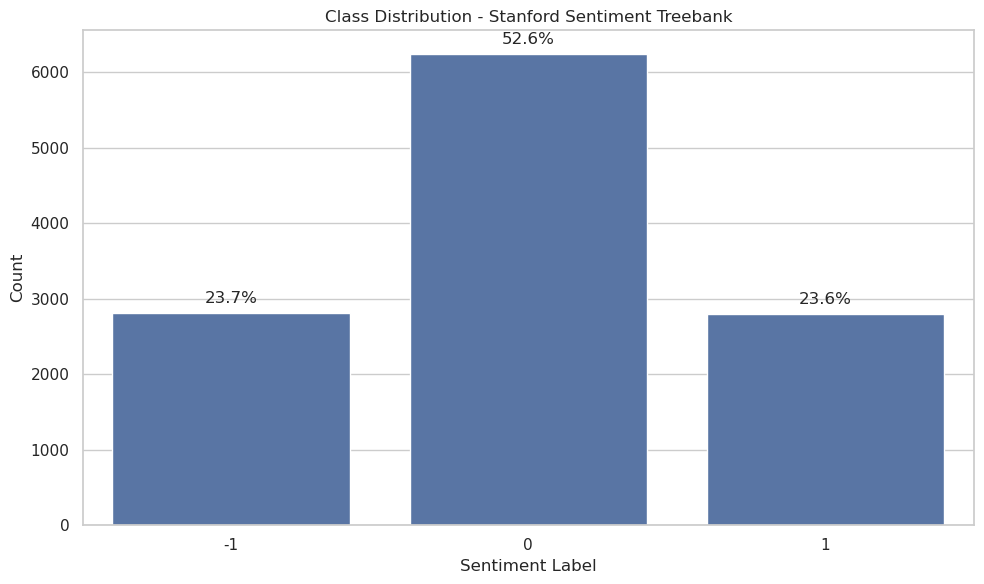

In [53]:
if sst_df is not None:
    check_class_imbalance(sst_df, title="Stanford Sentiment Treebank")

#### Reddit


Class Imbalance Analysis - Reddit Data
Total samples: 37249
Label counts: {1: 15830, 0: 13142, -1: 8277}
Imbalance ratio (max/min): 1.91


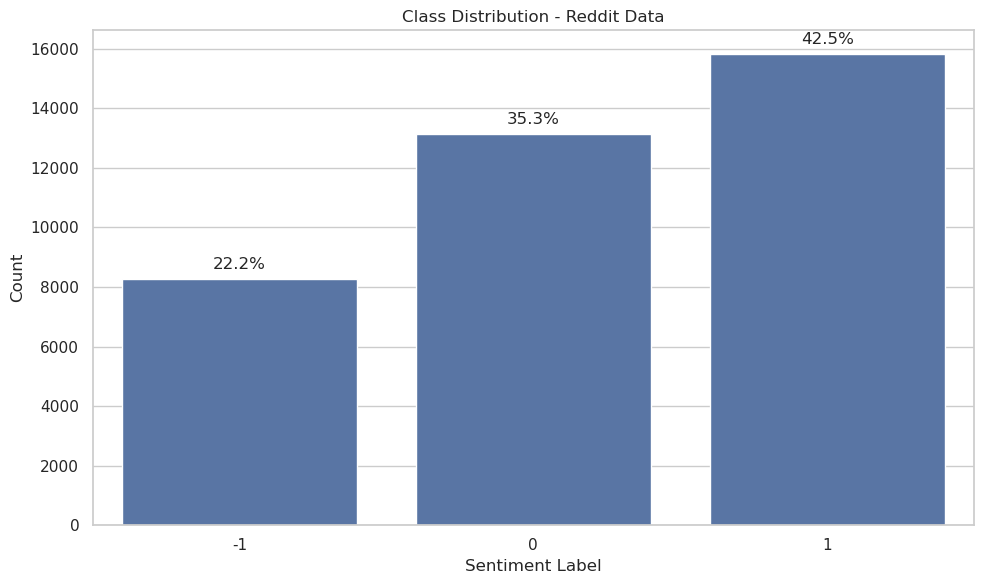

In [54]:
if reddit_df is not None:
    check_class_imbalance(reddit_df, title="Reddit Data")

## Text Preprocessing Test